---
## 8. 탄소중립 시나리오를 통한 사계절 길이 예측

#### 8-0. 라이브러리 호출

In [15]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#### 8-1. 데이터 호출

In [16]:
# 1959~2023 CO2 농도 데이터 호춯
temp_co2 = pd.read_csv('./DB/co2_mm_mlo.csv')
co2 = temp_co2.groupby('year')['average'].mean().reset_index()
co2.rename(columns={'average':'CO2(ppm)'}, inplace=True)

In [17]:
# 탄소중립 3가지 시나리오 CO2 농도 데이터 호출
local_zero = pd.read_csv('./DB/scenario_local_zero.csv')
fail_zero = pd.read_csv('./DB/scenario_not_zero.csv')
success_zero = pd.read_csv('./DB/scenario_global_zero.csv')

In [18]:
# 계절 길이 데이터 호출
season = pd.read_csv('./DB/4-season_2.csv')
season = season.drop('Unnamed: 0', axis=1).reset_index()
season.drop('index', axis=1, inplace=True)

In [19]:
# 이산화탄소 농도 & 계절길이 병합
merged_data = pd.merge(co2, season, on='year')
merged_data

,year,CO2(ppm),spring,summer,fall,winter
0,1959,315.980833,89,99,51,126
1,1960,316.910000,99,108,60,99
2,1961,317.644167,81,104,78,102
3,1962,318.454167,70,101,60,134
4,1963,318.992500,82,108,66,109
...,...,...,...,...,...,...
60,2019,411.654167,97,125,43,100
61,2020,414.238333,99,114,62,91
62,2021,416.450833,100,127,47,91
63,2022,418.564167,87,115,65,98


#### 8-2. SARIMAX 예측

#### **시나리오 1**

- 탄소중립 선언 국가만 목표 달성한 경우 사계절 길이 예측

In [20]:
# 탄소중립 시나리오
local_zero = pd.read_csv('./DB/scenario_local_zero.csv')

season_predictions = pd.DataFrame(index=range(2024, 2051), columns=['spring', 'summer', 'fall', 'winter'])

param = {
    'spring': [(0, 1, 1), (0, 1, 1, 12)],
    'summer': [(0, 0, 1), (0, 1, 1, 12)],
    'fall': [(0, 1, 1), (1, 1, 1, 12)],
    'winter': [(0, 1, 1), (1, 1, 1, 12)]
}

for season in ['spring', 'summer', 'fall', 'winter']:
    model = SARIMAX(merged_data[season], exog=merged_data['CO2(ppm)'], order=param[season][0], seasonal_order=param[season][1])
    fitted_model = model.fit(disp=False)
    
    predictions = fitted_model.predict(start=len(merged_data), end=len(merged_data) + len(local_zero) - 1, exog=local_zero['average'])
    season_predictions[season] = predictions.values

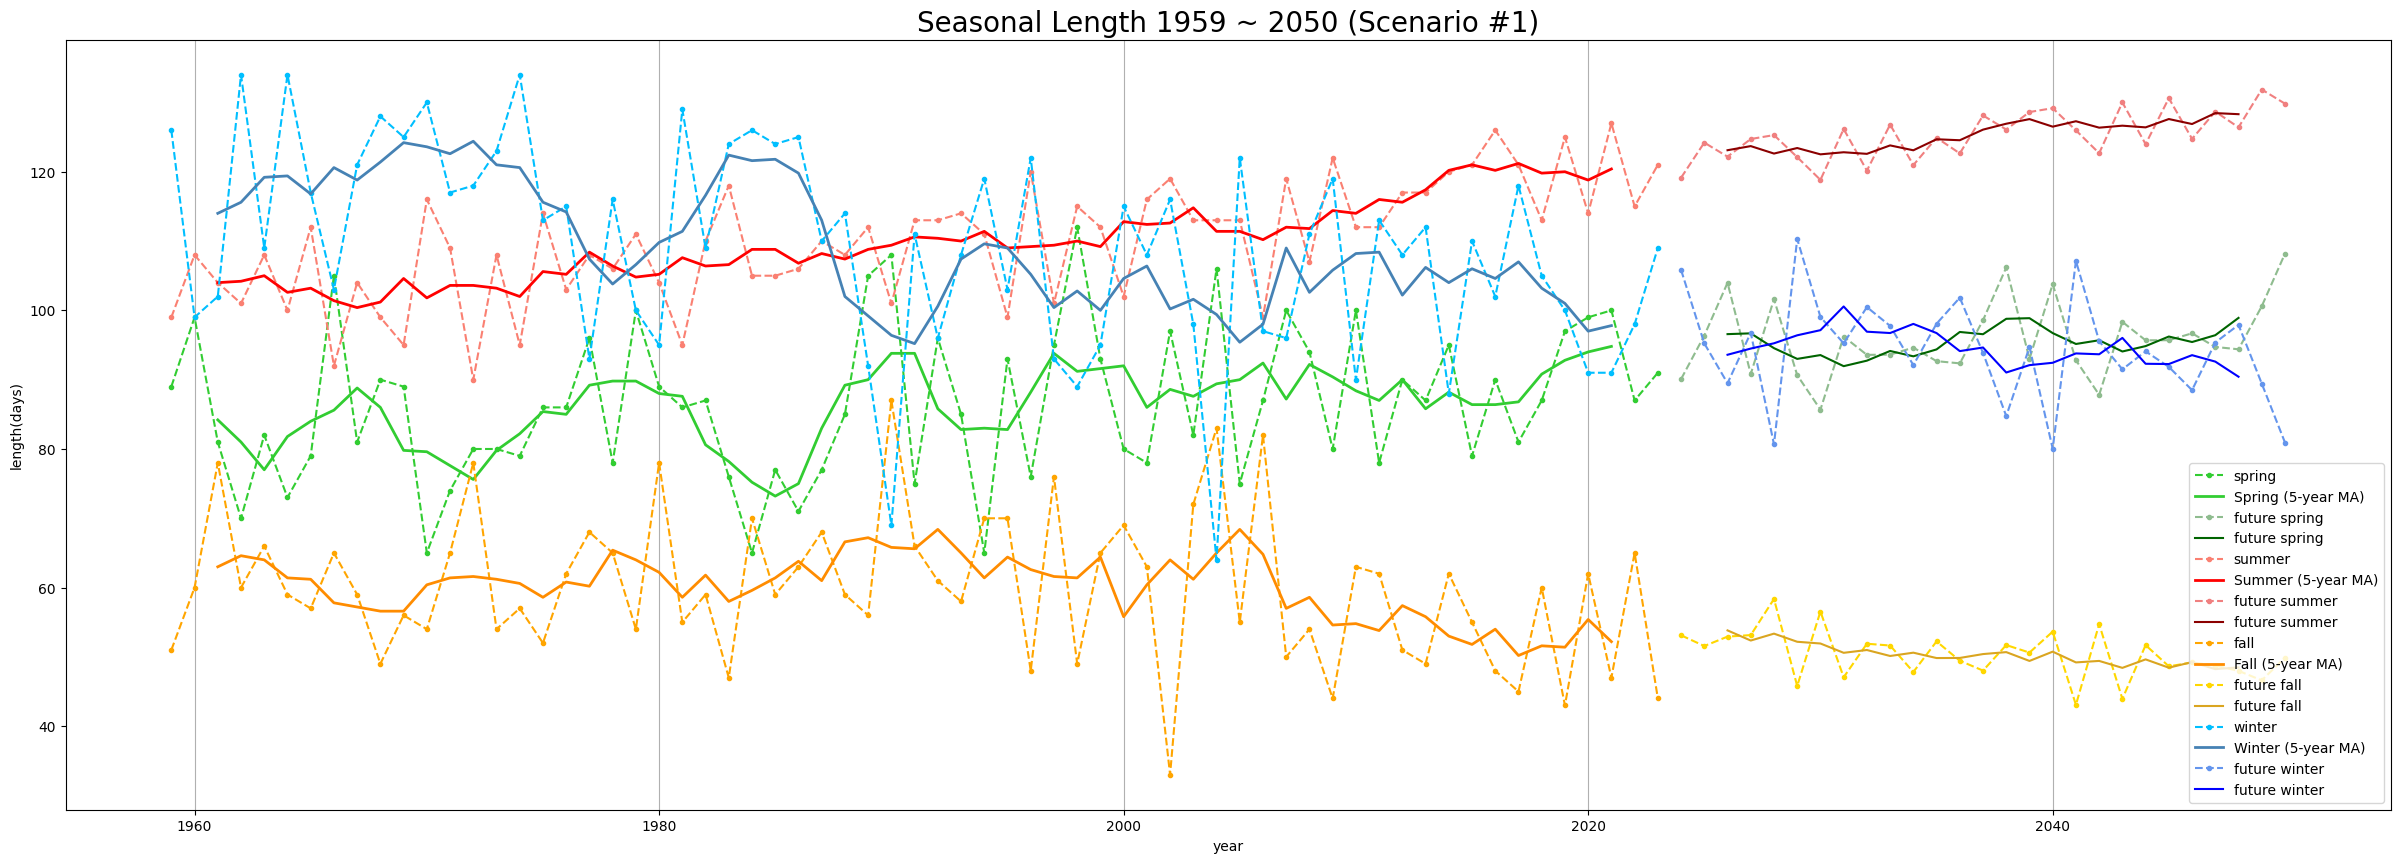

In [21]:
plt.figure(figsize=(30,10))

spring_ma = merged_data['spring'].rolling(window=5, center=True).mean()
summer_ma = merged_data['summer'].rolling(window=5, center=True).mean()
fall_ma = merged_data['fall'].rolling(window=5, center=True).mean()
winter_ma = merged_data['winter'].rolling(window=5, center=True).mean()

spring_ma_pred = season_predictions['spring'].rolling(window=5, center=True).mean()
summer_ma_pred = season_predictions['summer'].rolling(window=5, center=True).mean()
fall_ma_pred = season_predictions['fall'].rolling(window=5, center=True).mean()
winter_ma_pred = season_predictions['winter'].rolling(window=5, center=True).mean()

# 봄
plt.plot(merged_data['year'], merged_data['spring'], color='limegreen', marker='.', ls='--', label='spring')
plt.plot(merged_data['year'], spring_ma, label='Spring (5-year MA)', color='limegreen', linewidth=2)
plt.plot(season_predictions.index, season_predictions['spring'], color='darkseagreen', ls='--', marker='.', label='future spring')
plt.plot(season_predictions.index, spring_ma_pred, color='darkgreen', label='future spring')

# 여름
plt.plot(merged_data['year'], merged_data['summer'], color='salmon', marker='.', ls='--', label='summer')
plt.plot(merged_data['year'], summer_ma, label='Summer (5-year MA)', color='red', linewidth=2)
plt.plot(season_predictions.index, season_predictions['summer'], color='lightcoral', ls='--', marker='.', label='future summer')
plt.plot(season_predictions.index, summer_ma_pred, color='darkred', label='future summer')

# 가을
plt.plot(merged_data['year'], merged_data['fall'], color='orange', marker='.', ls='--', label='fall')
plt.plot(merged_data['year'], fall_ma, label='Fall (5-year MA)', color='darkorange', linewidth=2)
plt.plot(season_predictions.index, season_predictions['fall'], color='gold', marker='.', ls='--', label='future fall')
plt.plot(season_predictions.index, fall_ma_pred, color='goldenrod', label='future fall')

# 겨울
plt.plot(merged_data['year'], merged_data['winter'], color='deepskyblue', marker='.', ls='--', label='winter')
plt.plot(merged_data['year'], winter_ma, label='Winter (5-year MA)', color='steelblue', linewidth=2)
plt.plot(season_predictions.index, season_predictions['winter'], color='cornflowerblue', ls='--', marker='.', label='future winter')
plt.plot(season_predictions.index, winter_ma_pred, color='blue', label='future winter')

plt.title('Seasonal Length 1959 ~ 2050 (Scenario #1)', fontsize=20)
plt.grid(axis='x'); plt.xlabel('year'); plt.ylabel('length(days)')
plt.legend()
plt.show()

In [22]:
season_predictions.tail()

,spring,summer,fall,winter
2046,96.690433,124.746789,49.193145,88.487967
2047,94.719872,128.685848,48.746547,95.360757
2048,94.383019,126.407470,47.990467,97.906144
2049,100.590862,131.865503,46.614816,89.439571
2050,108.183212,129.823648,49.886048,80.932726


#### **시나리오 2**

- 모든 국가 탄소중립 실패의 경우 사계절 길이 예측

In [23]:
# 탄소중립 시나리오
local_zero = pd.read_csv('./DB/scenario_not_zero.csv')

season_predictions = pd.DataFrame(index=range(2024, 2051), columns=['spring', 'summer', 'fall', 'winter'])

param = {
    'spring': [(0, 1, 1), (0, 1, 1, 12)],
    'summer': [(0, 0, 1), (0, 1, 1, 12)],
    'fall': [(0, 1, 1), (1, 1, 1, 12)],
    'winter': [(0, 1, 1), (1, 1, 1, 12)]
}

for season in ['spring', 'summer', 'fall', 'winter']:
    model = SARIMAX(merged_data[season], exog=merged_data['CO2(ppm)'], order=param[season][0], seasonal_order=param[season][1])
    fitted_model = model.fit(disp=False)
    
    predictions = fitted_model.predict(start=len(merged_data), end=len(merged_data) + len(local_zero) - 1, exog=local_zero['average'])
    season_predictions[season] = predictions.values

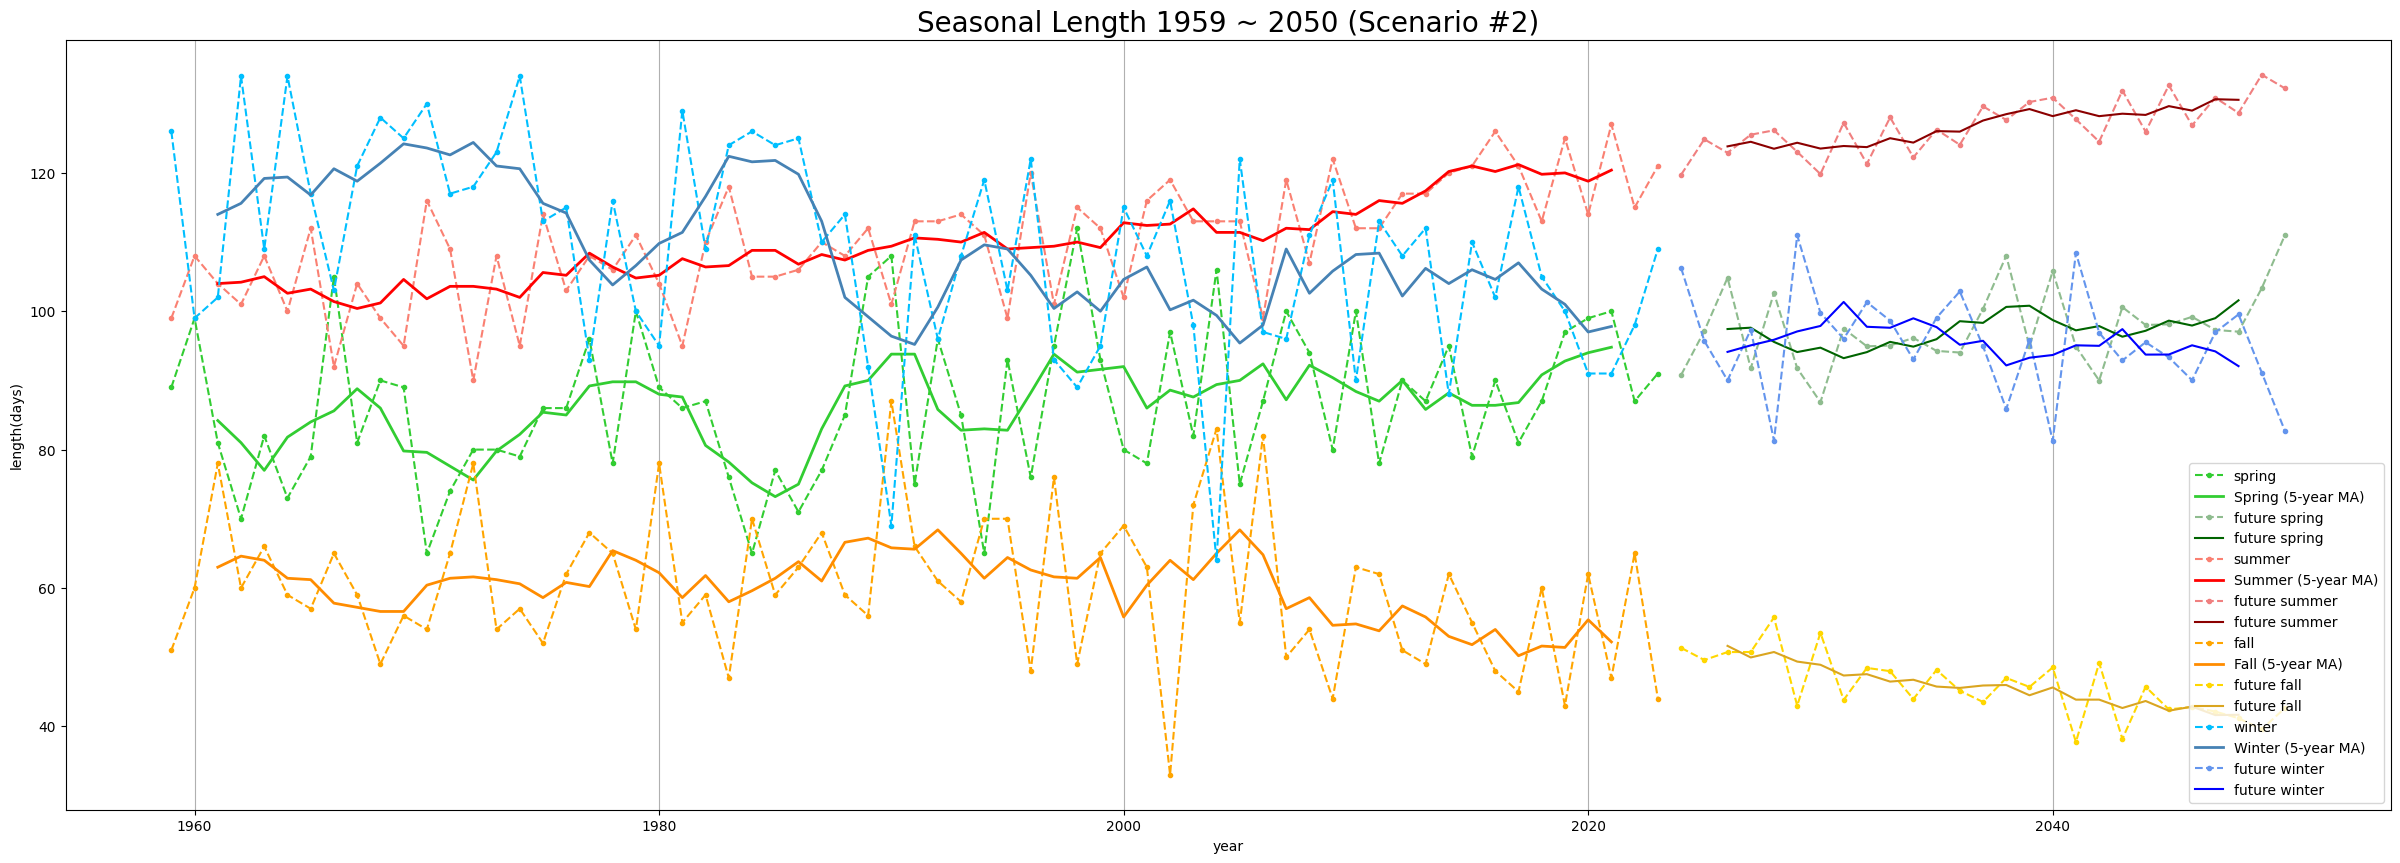

In [24]:
plt.figure(figsize=(30,10))

spring_ma = merged_data['spring'].rolling(window=5, center=True).mean()
summer_ma = merged_data['summer'].rolling(window=5, center=True).mean()
fall_ma = merged_data['fall'].rolling(window=5, center=True).mean()
winter_ma = merged_data['winter'].rolling(window=5, center=True).mean()

spring_ma_pred = season_predictions['spring'].rolling(window=5, center=True).mean()
summer_ma_pred = season_predictions['summer'].rolling(window=5, center=True).mean()
fall_ma_pred = season_predictions['fall'].rolling(window=5, center=True).mean()
winter_ma_pred = season_predictions['winter'].rolling(window=5, center=True).mean()

# 봄
plt.plot(merged_data['year'], merged_data['spring'], color='limegreen', marker='.', ls='--', label='spring')
plt.plot(merged_data['year'], spring_ma, label='Spring (5-year MA)', color='limegreen', linewidth=2)
plt.plot(season_predictions.index, season_predictions['spring'], color='darkseagreen', ls='--', marker='.', label='future spring')
plt.plot(season_predictions.index, spring_ma_pred, color='darkgreen', label='future spring')

# 여름
plt.plot(merged_data['year'], merged_data['summer'], color='salmon', marker='.', ls='--', label='summer')
plt.plot(merged_data['year'], summer_ma, label='Summer (5-year MA)', color='red', linewidth=2)
plt.plot(season_predictions.index, season_predictions['summer'], color='lightcoral', ls='--', marker='.', label='future summer')
plt.plot(season_predictions.index, summer_ma_pred, color='darkred', label='future summer')

# 가을
plt.plot(merged_data['year'], merged_data['fall'], color='orange', marker='.', ls='--', label='fall')
plt.plot(merged_data['year'], fall_ma, label='Fall (5-year MA)', color='darkorange', linewidth=2)
plt.plot(season_predictions.index, season_predictions['fall'], color='gold', marker='.', ls='--', label='future fall')
plt.plot(season_predictions.index, fall_ma_pred, color='goldenrod', label='future fall')

# 겨울
plt.plot(merged_data['year'], merged_data['winter'], color='deepskyblue', marker='.', ls='--', label='winter')
plt.plot(merged_data['year'], winter_ma, label='Winter (5-year MA)', color='steelblue', linewidth=2)
plt.plot(season_predictions.index, season_predictions['winter'], color='cornflowerblue', ls='--', marker='.', label='future winter')
plt.plot(season_predictions.index, winter_ma_pred, color='blue', label='future winter')

plt.title('Seasonal Length 1959 ~ 2050 (Scenario #2)', fontsize=20)
plt.grid(axis='x'); plt.xlabel('year'); plt.ylabel('length(days)')
plt.legend()
plt.show()

In [25]:
season_predictions.tail()

,spring,summer,fall,winter
2046,99.189795,126.864781,42.788664,90.028043
2047,97.301335,130.873413,42.131686,96.951422
2048,97.046584,128.664609,41.165227,99.547399
2049,103.336528,134.192216,39.579196,91.131416
2050,111.010979,132.219934,42.640049,82.675160


#### **시나리오 3**

- 전세계 탄소중립을 달성한 경우 사계절 길이 예측

In [26]:
# 탄소중립 시나리오
local_zero = pd.read_csv('./DB/scenario_global_zero.csv')

season_predictions = pd.DataFrame(index=range(2024, 2051), columns=['spring', 'summer', 'fall', 'winter'])

param = {
    'spring': [(0, 1, 1), (0, 1, 1, 12)],
    'summer': [(0, 0, 1), (0, 1, 1, 12)],
    'fall': [(0, 1, 1), (1, 1, 1, 12)],
    'winter': [(0, 1, 1), (1, 1, 1, 12)]
}

for season in ['spring', 'summer', 'fall', 'winter']:
    model = SARIMAX(merged_data[season], exog=merged_data['CO2(ppm)'], order=param[season][0], seasonal_order=param[season][1])
    fitted_model = model.fit(disp=False)
    
    predictions = fitted_model.predict(start=len(merged_data), end=len(merged_data) + len(local_zero) - 1, exog=local_zero['average'])
    season_predictions[season] = predictions.values

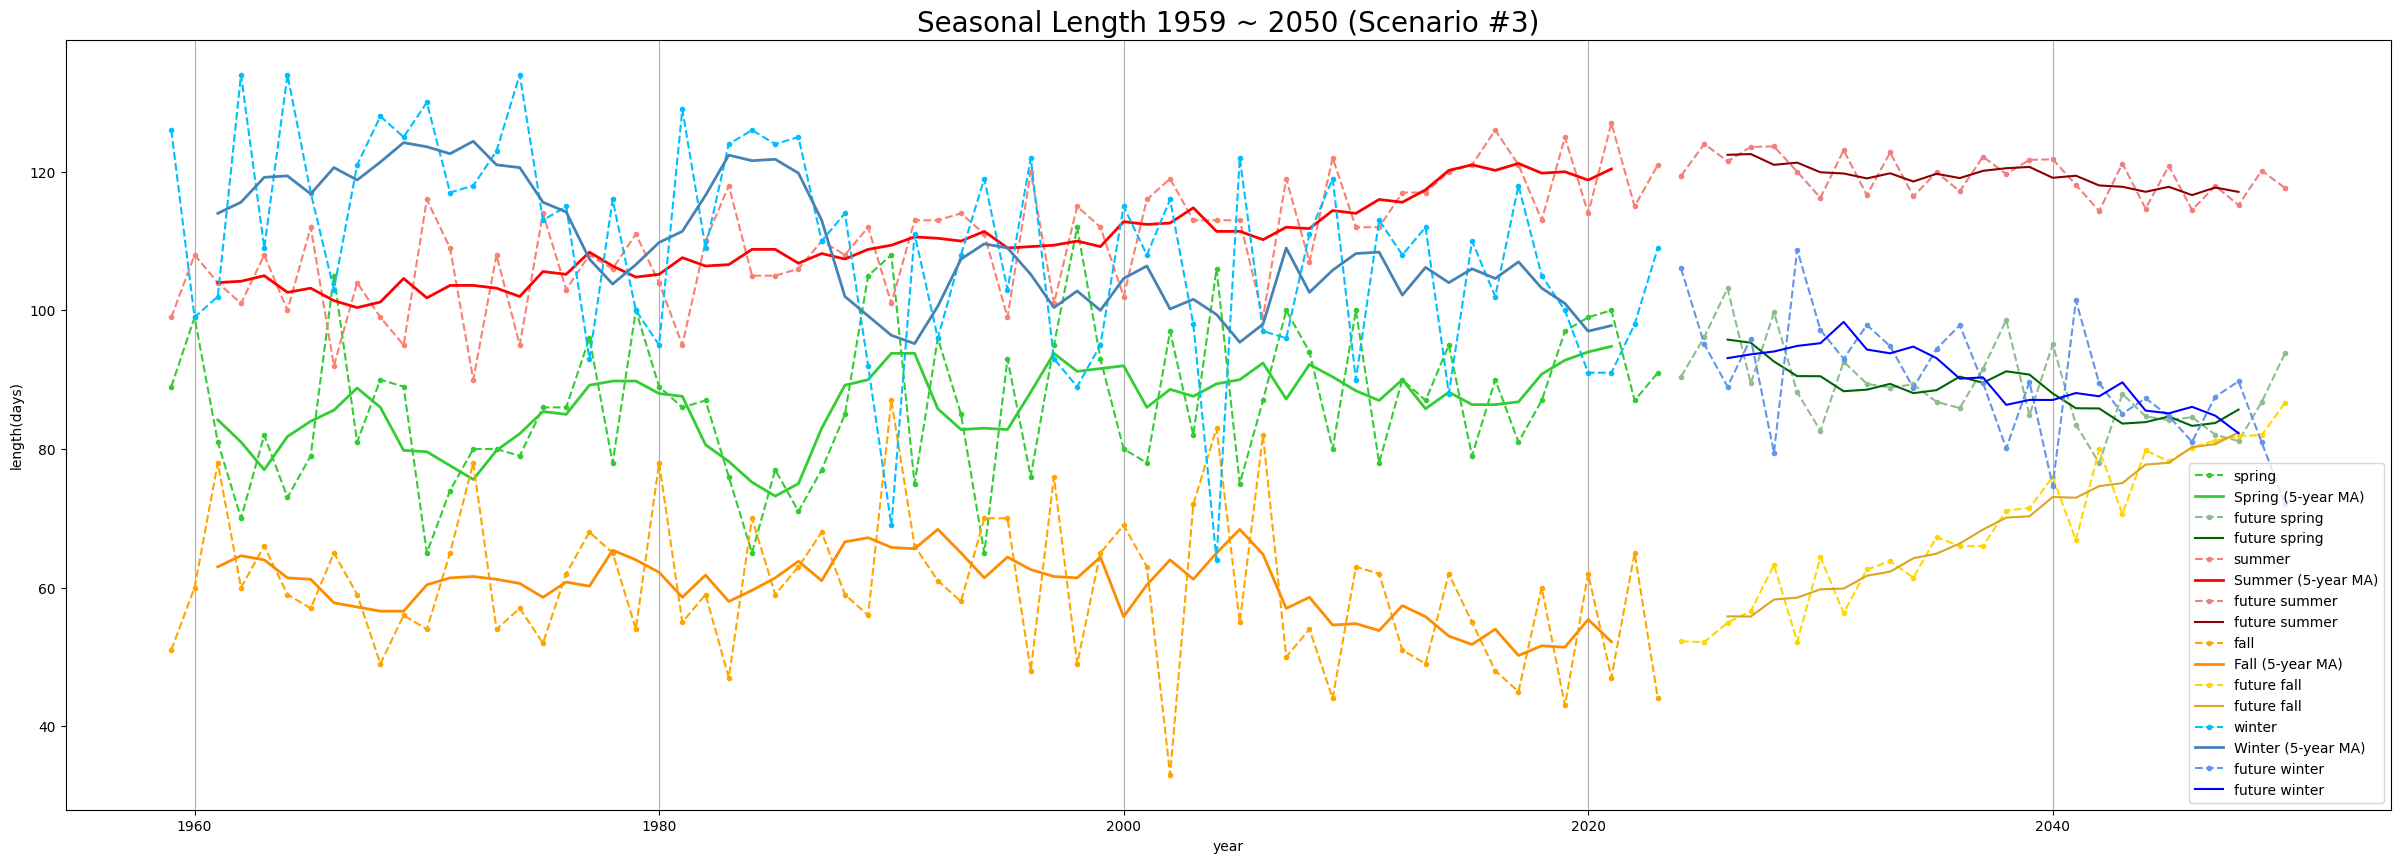

In [27]:
plt.figure(figsize=(30,10))

spring_ma = merged_data['spring'].rolling(window=5, center=True).mean()
summer_ma = merged_data['summer'].rolling(window=5, center=True).mean()
fall_ma = merged_data['fall'].rolling(window=5, center=True).mean()
winter_ma = merged_data['winter'].rolling(window=5, center=True).mean()

spring_ma_pred = season_predictions['spring'].rolling(window=5, center=True).mean()
summer_ma_pred = season_predictions['summer'].rolling(window=5, center=True).mean()
fall_ma_pred = season_predictions['fall'].rolling(window=5, center=True).mean()
winter_ma_pred = season_predictions['winter'].rolling(window=5, center=True).mean()

# 봄
plt.plot(merged_data['year'], merged_data['spring'], color='limegreen', marker='.', ls='--', label='spring')
plt.plot(merged_data['year'], spring_ma, label='Spring (5-year MA)', color='limegreen', linewidth=2)
plt.plot(season_predictions.index, season_predictions['spring'], color='darkseagreen', ls='--', marker='.', label='future spring')
plt.plot(season_predictions.index, spring_ma_pred, color='darkgreen', label='future spring')

# 여름
plt.plot(merged_data['year'], merged_data['summer'], color='salmon', marker='.', ls='--', label='summer')
plt.plot(merged_data['year'], summer_ma, label='Summer (5-year MA)', color='red', linewidth=2)
plt.plot(season_predictions.index, season_predictions['summer'], color='lightcoral', ls='--', marker='.', label='future summer')
plt.plot(season_predictions.index, summer_ma_pred, color='darkred', label='future summer')

# 가을
plt.plot(merged_data['year'], merged_data['fall'], color='orange', marker='.', ls='--', label='fall')
plt.plot(merged_data['year'], fall_ma, label='Fall (5-year MA)', color='darkorange', linewidth=2)
plt.plot(season_predictions.index, season_predictions['fall'], color='gold', marker='.', ls='--', label='future fall')
plt.plot(season_predictions.index, fall_ma_pred, color='goldenrod', label='future fall')

# 겨울
plt.plot(merged_data['year'], merged_data['winter'], color='deepskyblue', marker='.', ls='--', label='winter')
plt.plot(merged_data['year'], winter_ma, label='Winter (5-year MA)', color='steelblue', linewidth=2)
plt.plot(season_predictions.index, season_predictions['winter'], color='cornflowerblue', ls='--', marker='.', label='future winter')
plt.plot(season_predictions.index, winter_ma_pred, color='blue', label='future winter')

plt.title('Seasonal Length 1959 ~ 2050 (Scenario #3)', fontsize=20)
plt.grid(axis='x'); plt.xlabel('year'); plt.ylabel('length(days)')
plt.legend()
plt.show()

In [28]:
# 아마도 겨울 길이가 회복되는 과정에서 가을을 거치기에 가을의 길이가 늘어난 것으로 예측
season_predictions.tail()

,spring,summer,fall,winter
2046,84.588656,114.491586,80.203294,81.031005
2047,82.052448,117.951307,81.206136,87.555250
2048,81.149948,115.193593,81.899497,89.752093
2049,86.792143,120.172289,81.973287,80.936976
2050,93.818846,117.651097,86.693959,72.081585


## **결론**

- **지구 온난화** 해결은 전 세계가 함께하는 **조별 과제**
- **탄소배출량이 많은 국가**들의 참여 없이 탄소중립 정책의 실효성을 기대하기 어려움
- 더 많은 국가가 탄소중립에 참여한다면, 계절 길이 회복 및 지구 온난화 해결이 가능할 것으로 전망